In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from networks_2022 import BranchedNetwork
from data.CleanSoundsDataset import CleanSoundsDataset

# Parameters

In [2]:
engram_dir = '/mnt/smb/locker/issa-locker/users/Erica/'

In [3]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

checkpoints_dir = f'{engram_dir}hcnn/checkpoints/'
tensorboard_dir = f'{engram_dir}hcnn/tensorboard/'
datafile = f'{engram_dir}seed_542_word_clean_random_order.hdf5'

Device: cuda:0


In [4]:
from pbranchednetwork_a1 import PBranchedNetwork_A1SeparateHP
PNetClass = PBranchedNetwork_A1SeparateHP
pnet_name = 'a1'
p_layers = 'Layers 1-3'

In [5]:
from pbranchednetwork_all import PBranchedNetwork_AllSeparateHP
PNetClass = PBranchedNetwork_AllSeparateHP
pnet_name = 'all'
p_layers = 'All Layers'

# Load network

In [6]:
net = BranchedNetwork()
net.load_state_dict(torch.load(f'{engram_dir}networks_2022_weights.pt'))

/share/issa/users/es3773/temp-hallucnn/src/models/layers.py:78: UserWarning: Inconsistent tf pad calculation in ConvLayer.
  warnings.warn('Inconsistent tf pad calculation in ConvLayer.')
/share/issa/users/es3773/temp-hallucnn/src/models/layers.py:173: UserWarning: Inconsistent tf pad calculation: 0, 1
  warnings.warn(f'Inconsistent tf pad calculation: {pad_left}, {pad_right}')


<All keys matched successfully>

In [7]:
pnet = PNetClass(net, build_graph=True)

In [8]:
def print_hps(pnet):
    for pc in range(pnet.number_of_pcoders):
        print (f"PCoder{pc+1} : ffm: {getattr(pnet,f'ffm{pc+1}'):0.3f} \t fbm: {getattr(pnet,f'fbm{pc+1}'):0.3f} \t erm: {getattr(pnet,f'erm{pc+1}'):0.3f}")

In [9]:
pnet.load_state_dict(torch.load(
    f"{checkpoints_dir}{pnet_name}/{pnet_name}-50-regular.pth",
    map_location='cpu'
    ))
pnet.to(DEVICE)
pnet.build_graph = False        # only required for training
pnet.eval();
print_hps(pnet)

PCoder1 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder2 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder3 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder4 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder5 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010


# First timestep reconstruction of Clean Sounds Dataset

In [9]:
full_dataset = CleanSoundsDataset(datafile)
n_train = int(len(full_dataset)*0.9)
eval_dataset = Subset(full_dataset, np.arange(n_train, len(full_dataset)))

In [10]:
del full_dataset

/share/issa/users/es3773/predify/predify/modules/base.py:260: UserWarning: Using a target size (torch.Size([1, 164, 400])) that is different to the input size (torch.Size([1, 1, 164, 400])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.prediction_error  = nn.functional.mse_loss(self.prd, target)
/home/es3773/.local/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


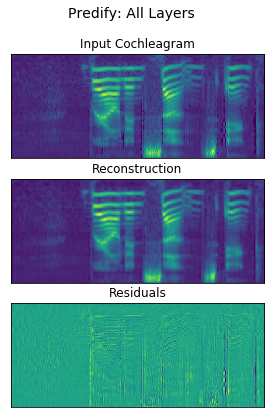

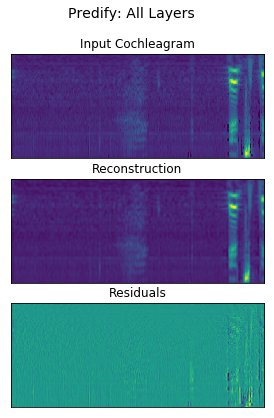

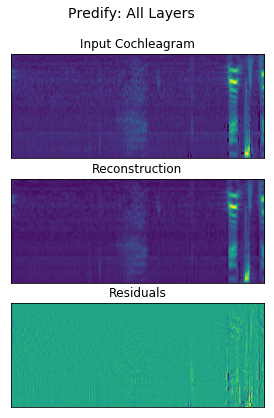

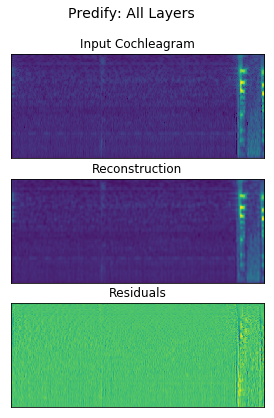

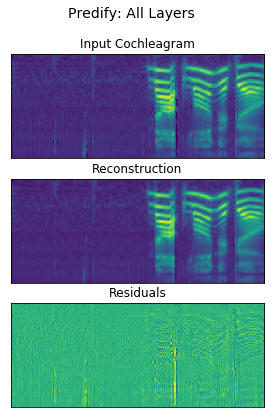

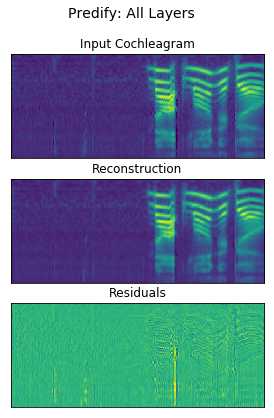

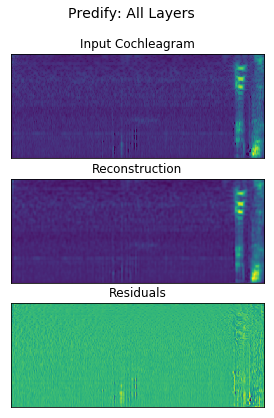

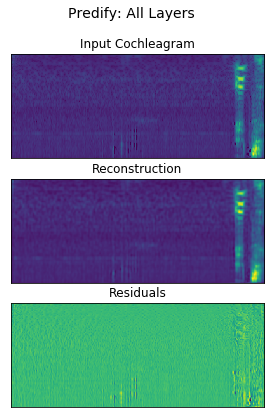

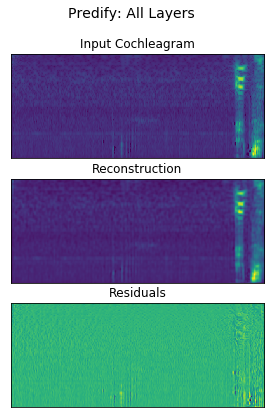

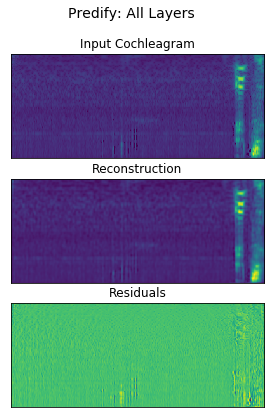

In [11]:
for i in range(10):
    img = np.array(eval_dataset[i][0]).squeeze()
    pnet.reset()
    with torch.no_grad():
        _input = eval_dataset[i][0].to(DEVICE)
        outputs = pnet(_input)
    reconstruction = np.array(pnet.pcoder1.prd.cpu()).squeeze()
    residuals = img - reconstruction
    
    fig, axs = plt.subplots(3, 1, figsize = (6.4, 6.5))
    axs[0].imshow(img)
    axs[0].set_title('Input Cochleagram')
    axs[1].imshow(reconstruction)
    axs[1].set_title('Reconstruction')
    axs[2].imshow(residuals)
    axs[2].set_title('Residuals')
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle(f'Predify: {p_layers}', fontsize=14)
    plt.show()

# Plot reconstructions over successive timesteps

In [17]:
from scipy.stats import pearsonr

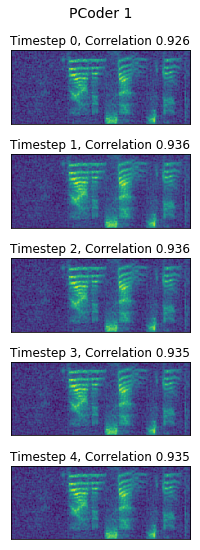

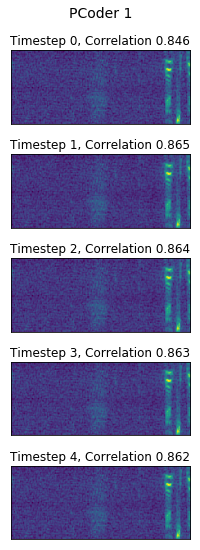

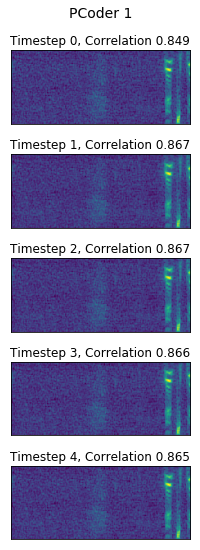

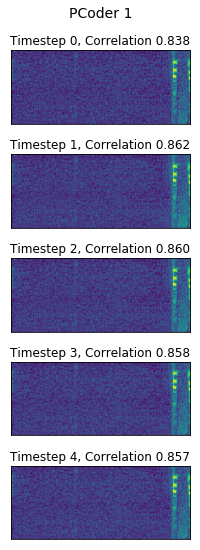

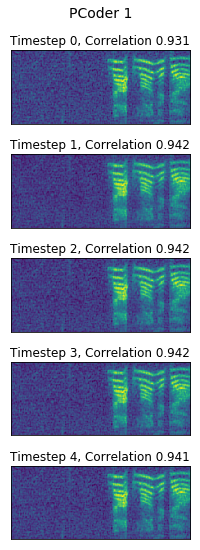

In [31]:
n_timesteps = 5
for i in range(5):
    img = np.array(eval_dataset[i][0]).squeeze()
    pnet.reset()
    fig, axs = plt.subplots(5, 1, figsize = (6, 8))
    with torch.no_grad():
        clean_input = eval_dataset[i][0].clone()
        for j in range(n_timesteps):
            _input = eval_dataset[i][0] if j == 0 else None
            if _input is not None:
                _input = _input + torch.normal(0, 80, size=_input.shape)
                _input = _input.to(DEVICE)
            outputs = pnet(_input)
            reconstruction = np.array(pnet.pcoder1.prd[0,0].cpu())
            corr, _ = pearsonr(reconstruction.flatten(), clean_input.flatten())
            axs[j].imshow(reconstruction)
            axs[j].set_title(f'Timestep {j}, Correlation {corr:.3f}')
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle(f'PCoder 1', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Load PsychoPhysics Dataset

In [10]:
import h5py

In [11]:
f_in = h5py.File(f"{engram_dir}PsychophysicsWord2017W_not_resampled.hdf5", 'r')

In [12]:
f_metadata = np.load(f"{engram_dir}PsychophysicsWord2017W_999c6fc475be1e82e114ab9865aa5459e4fd329d.__META.npy", 'r')

In [13]:
f_key = np.load(f"{engram_dir}PsychophysicsWord2017W_999c6fc475be1e82e114ab9865aa5459e4fd329d.__META_key.npy", 'r')

In [48]:
def getPsychophysics2017WCleanCochleagrams():
    
    cochleagrams_clean = []
   
    cochleagrams = []
    for batch_ii in range(0,15300,100):
        hdf5_path = '/mnt/smb/locker/issa-locker/users/Erica/cgrams_for_noise_robustness_analysis/PsychophysicsWord2017W_clean/batch_'+str(batch_ii)+'_to_'+str(batch_ii+100)+'.hdf5'
        with h5py.File(hdf5_path, 'r') as f_in:
            cochleagrams += list(f_in['data'])

    return cochleagrams
clean_in = getPsychophysics2017WCleanCochleagrams()

In [14]:
labels = []
for word in f_metadata['word']:
    idx = np.argwhere(f_key == word)
    if len(idx) == 0:
        labels.append(-1)
    else:
        labels.append(idx.item())
labels = np.array(labels)
labels += 1

In [15]:
bg = []
for _bg in f_metadata['bg']:
    bg.append(str(_bg, 'utf-8'))
bg = np.array(bg)

In [16]:
snr = []
for _snr in f_metadata['snr']:
    snr.append(str(_snr, 'utf-8'))
snr = np.array(snr)

In [49]:
def plot_reconstructions(
    bg_type='n/a', snr_type=None, noise_std=0 
    ):
    
    dset_idxs = bg == bg_type
    if snr_type is not None:
        dset_idxs = np.logical_and(dset_idxs, snr==snr_type)
    dset_idxs = np.argwhere(dset_idxs).squeeze()
    
    n_timesteps = 8
    for i in range(10):
        idx = dset_idxs[i]
        label = labels[idx]
        _input = torch.tensor(f_in['data'][idx].reshape((1, 1, 164, 400)))
        if snr_type is None:
            clean_input = _input.clone()
        else:
            clean_input = clean_in[idx]
            clean_input = torch.tensor(clean_input.reshape((1, 1, 164, 400))).clone()
        _label = labels[idx]
        pnet.reset()
        fig, axs = plt.subplots(8, 1, figsize = (6,10))
        with torch.no_grad():
            for j in range(n_timesteps):
                _input = _input if j == 0 else None
                if _input is not None:
                    _input = _input + torch.normal(0, noise_std, size=_input.shape)
                    _input = _input.to(DEVICE)
                outputs, _ = pnet(_input)
                output = outputs.max(-1)[1].item()
                reconstruction = np.array(pnet.pcoder1.prd[0,0].cpu())
                corr, _ = pearsonr(reconstruction.flatten(), clean_input.flatten())
                axs[j].imshow(reconstruction)
                axs[j].set_title(f't = {j}, corr = {corr:.3f}, pred = {output}')
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])
        plt.suptitle(f'PCoder 1, Correct label {_label}', fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Reconstructions for Gaussian Noise

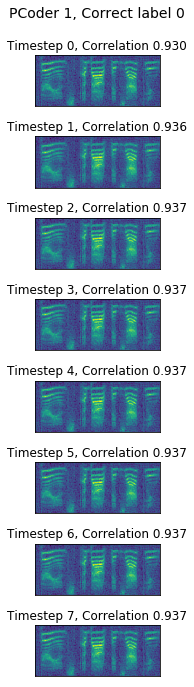

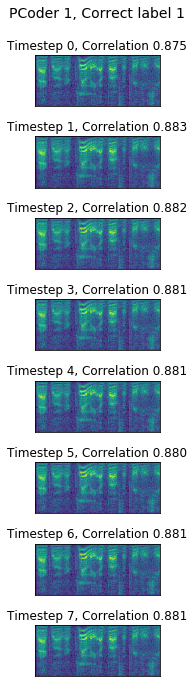

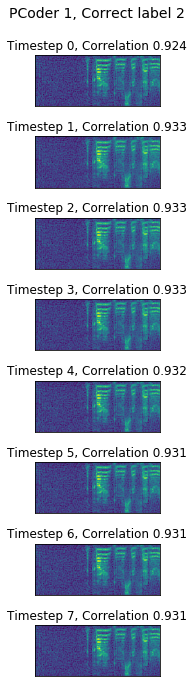

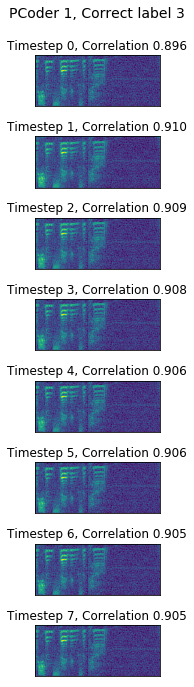

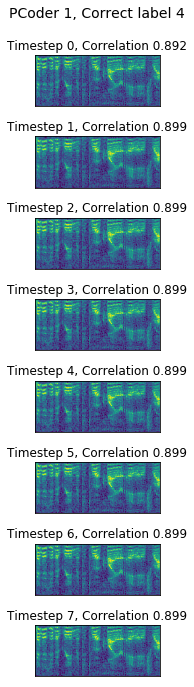

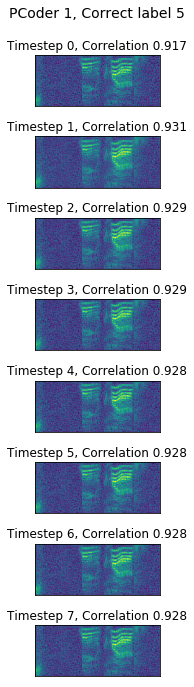

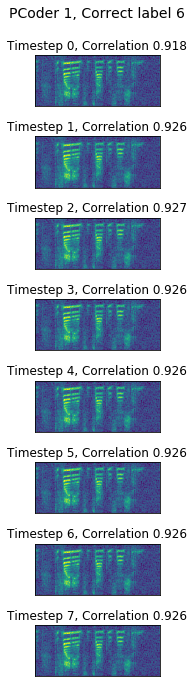

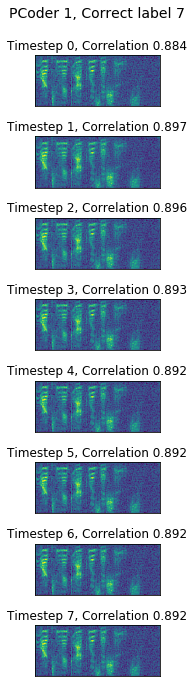

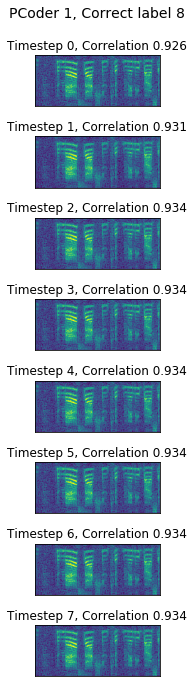

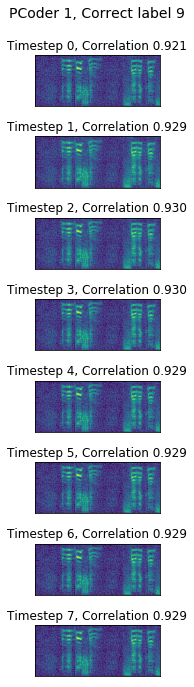

In [32]:
plot_reconstructions(bg_type='n/a', snr_type=None, noise_std=80)

# Reconstructions for Auditory Scene

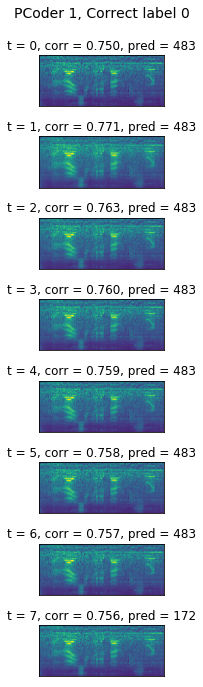

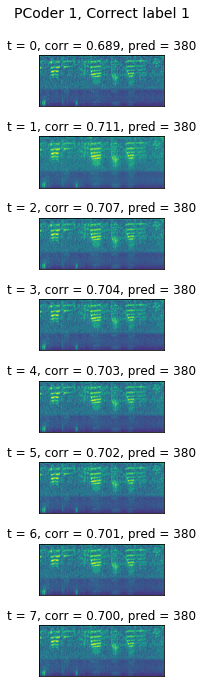

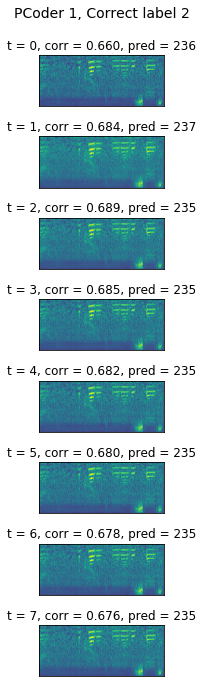

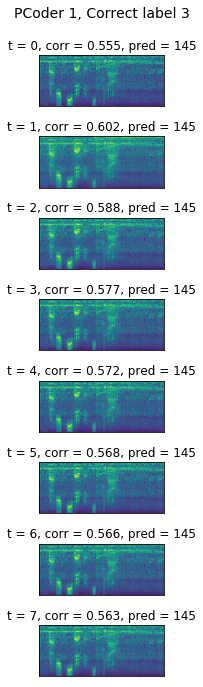

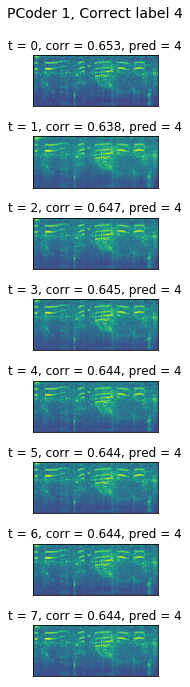

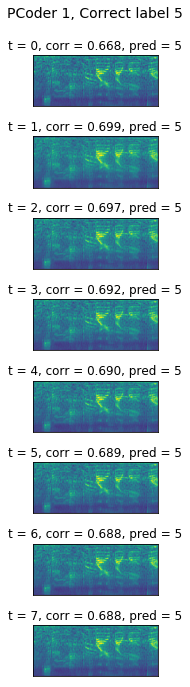

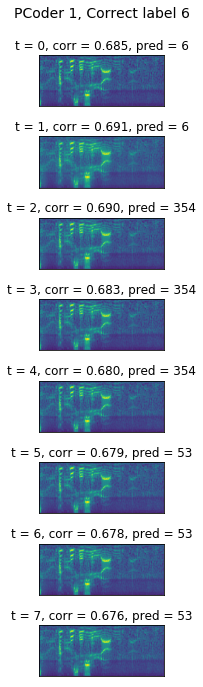

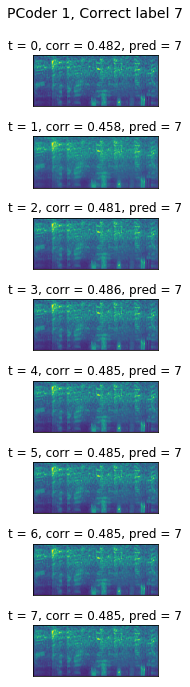

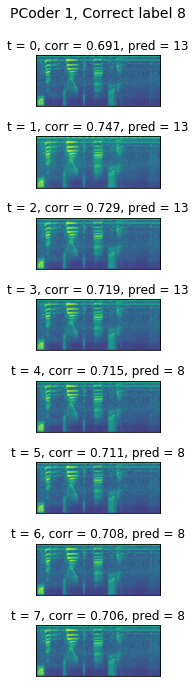

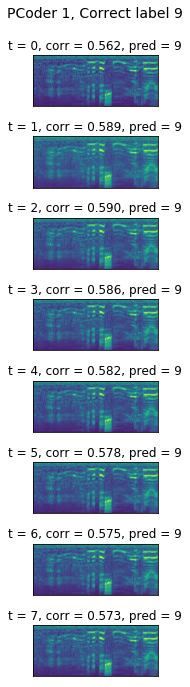

In [50]:
plot_reconstructions(bg_type='AudScene', snr_type='3db', noise_std=0)

# Reconstructions for Babble 2 Spkr

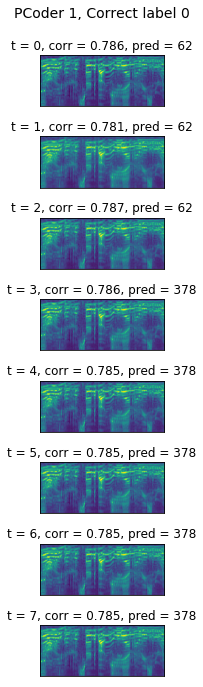

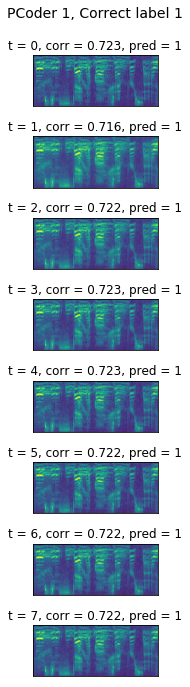

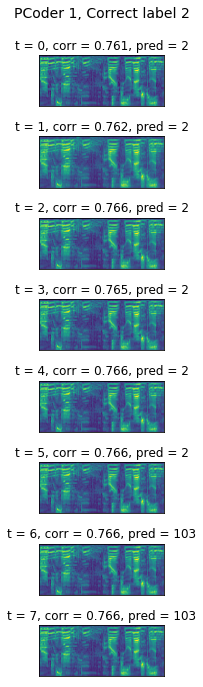

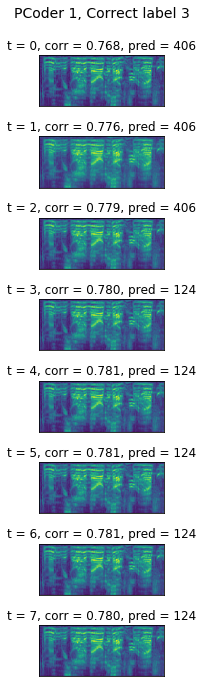

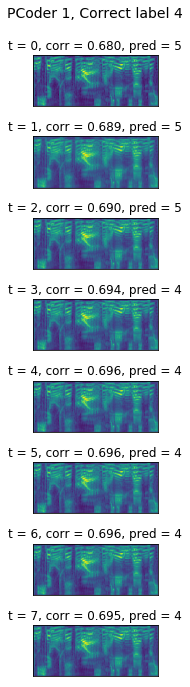

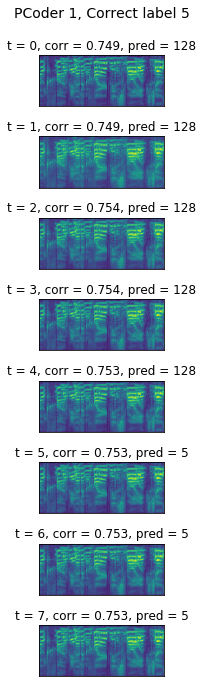

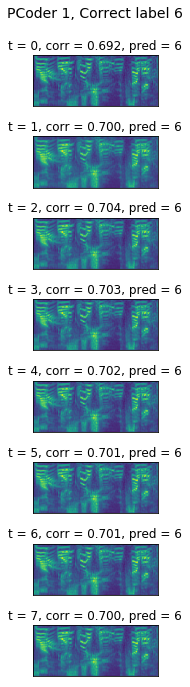

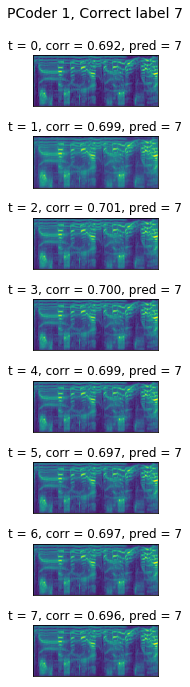

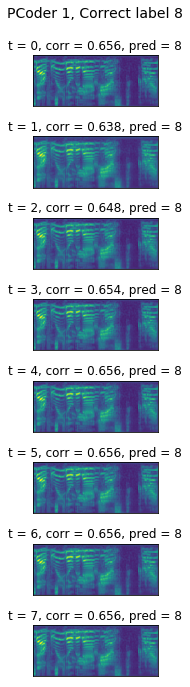

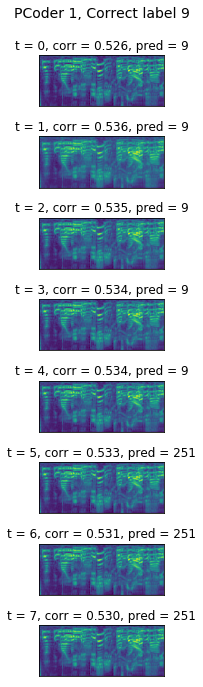

In [52]:
plot_reconstructions(bg_type='Babble2Spkr', snr_type='3db', noise_std=0)

# Reconstructions for Babble 8 Spkr

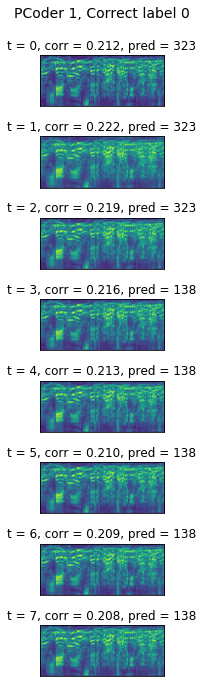

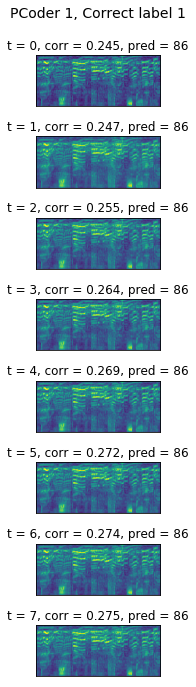

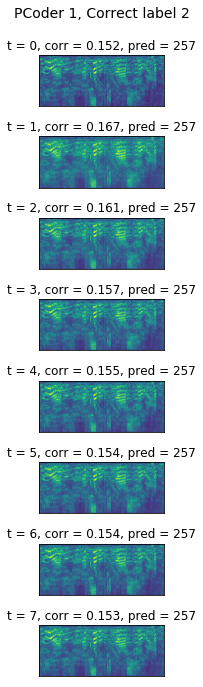

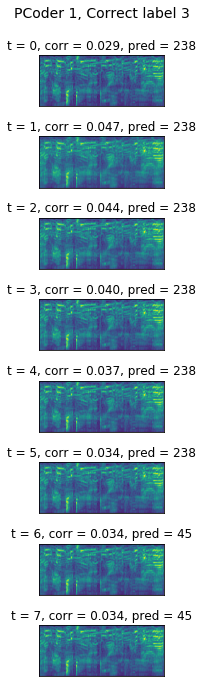

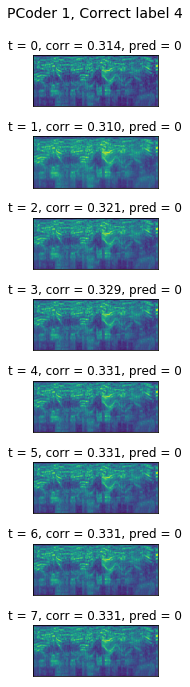

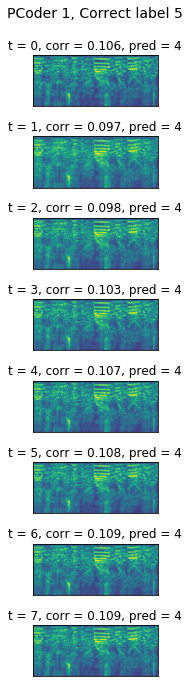

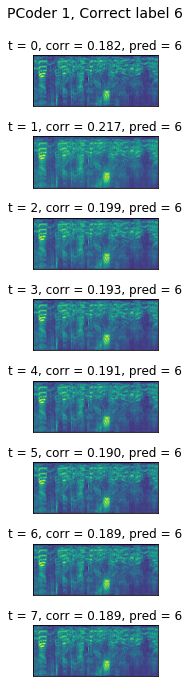

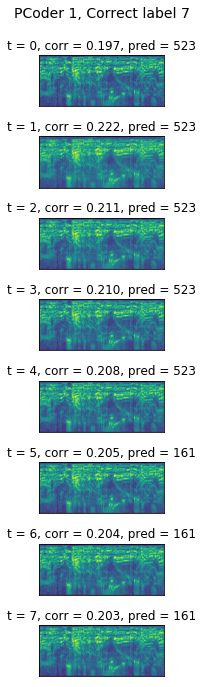

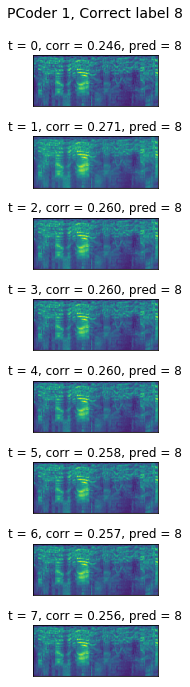

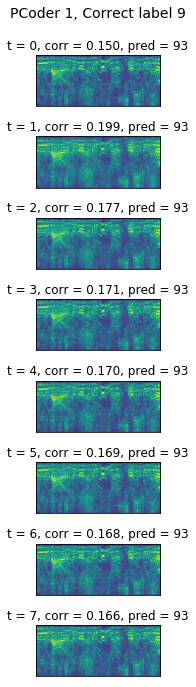

In [45]:
plot_reconstructions(bg_type='Babble8Spkr', snr_type='3db', noise_std=0)

In [33]:
np.unique(snr)

array(['0db', '3db', 'inf', 'neg3db', 'neg6db', 'neg9db'], dtype='<U6')

In [21]:
np.unique(bg)

array(['AudScene', 'Babble2Spkr', 'Babble8Spkr', 'Music',
       'SpeakerShapedNoise', 'n/a'], dtype='<U18')